## Imports

In [81]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotnine as p9
import statsmodels.formula.api as smf

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Load Yahoo Data

We will be getting Dividend Adjusted data -> which could be the difference between Yahoo and TradingView data

In [82]:
# tickers = ['SPY', 'TLT']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True)   # get dividend adjusted prices

Convert Yahoo Data to long-format

In [83]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(1, future_stack=True)
#     .reset_index()
#     [['Date', 'Ticker', 'Close']]
#     .sort_values(by=['Date', 'Ticker'])
# )

# data.head(5)

In [84]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_SPY_TLT_2002-07-30_D.csv', index=False)

## Create return data for the various periods of Month defined by (N, M)

In [85]:
# read data from csv
data = pd.read_csv('data_SPY_TLT_2002-07-30_D.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11704 entries, 0 to 11703
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11704 non-null  datetime64[ns]
 1   Ticker  11704 non-null  object        
 2   Close   11704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 274.4+ KB
None
        Date Ticker      Close
0 2002-07-30    SPY  59.177723
1 2002-07-30    TLT  37.055679
2 2002-07-31    SPY  59.320908
3 2002-07-31    TLT  37.514790
4 2002-08-01    SPY  57.772160


In [86]:
# Add year-month label (end of month date)

# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'ym' representing the last day of each month
data['ym'] = data['Date'] + pd.offsets.MonthEnd(0)

data.head()

,Date,Ticker,Close,ym
0,2002-07-30,SPY,59.177723,2002-07-31
1,2002-07-30,TLT,37.055679,2002-07-31
2,2002-07-31,SPY,59.320908,2002-07-31
3,2002-07-31,TLT,37.514790,2002-07-31
4,2002-08-01,SPY,57.772160,2002-08-31


In [87]:
# Create trading-day counter for each Ticker and month

# Sort data to ensure correct order
data = data.sort_values(['Ticker', 'Date']).copy()

# Count trading days within each (Ticker, ym) group
data['td'] = data.groupby(['Ticker', 'ym']).cumcount() + 1

data.head()

,Date,Ticker,Close,ym,td
0,2002-07-30,SPY,59.177723,2002-07-31,1
2,2002-07-31,SPY,59.320908,2002-07-31,2
4,2002-08-01,SPY,57.772160,2002-08-31,1
6,2002-08-02,SPY,56.477177,2002-08-31,2
8,2002-08-05,SPY,54.511963,2002-08-31,3


In [88]:
#  Calculate daily simple returns

# Calculate percentage change of 'Close' within each ticker
data['ret'] = data.groupby('Ticker')['Close'].pct_change()

data.head()

,Date,Ticker,Close,ym,td,ret
0,2002-07-30,SPY,59.177723,2002-07-31,1,NaN
2,2002-07-31,SPY,59.320908,2002-07-31,2,0.002420
4,2002-08-01,SPY,57.772160,2002-08-31,1,-0.026108
6,2002-08-02,SPY,56.477177,2002-08-31,2,-0.022415
8,2002-08-05,SPY,54.511963,2002-08-31,3,-0.034797


In [89]:
# Filter dates and keep only needed columns

# Keep data from August 2002 onwards
data = data[data['Date'] >= pd.Timestamp(2002, 8, 1)]

# Keep only useful columns
data = data[['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]

data.head()

,Date,ym,Ticker,Close,ret,td
4,2002-08-01,2002-08-31,SPY,57.772160,-0.026108,1
6,2002-08-02,2002-08-31,SPY,56.477177,-0.022415,2
8,2002-08-05,2002-08-31,SPY,54.511963,-0.034797,3
10,2002-08-06,2002-08-31,SPY,56.347069,0.033664,4
12,2002-08-07,2002-08-31,SPY,57.329643,0.017438,5


In [90]:
# Create start/end/month flags and conditional returns

N = 15  # number of days for start of month
M = 5   # number of days for next start of month

# Flags: 1 if condition true, 0 otherwise
data['som_flag'] = (data['td'] <= N).astype(int)
data['eom_flag'] = (data['td'] > N).astype(int)
data['nsm_flag'] = (data['td'] <= M).astype(int)

# Conditional returns (return only within flag period)
data['ret_som'] = data['ret'] * data['som_flag']
data['ret_eom'] = data['ret'] * data['eom_flag']
data['ret_nsm'] = data['ret'] * data['nsm_flag']

data.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
4,2002-08-01,2002-08-31,SPY,57.772160,-0.026108,1,1,0,1,-0.026108,-0.0,-0.026108
6,2002-08-02,2002-08-31,SPY,56.477177,-0.022415,2,1,0,1,-0.022415,-0.0,-0.022415
8,2002-08-05,2002-08-31,SPY,54.511963,-0.034797,3,1,0,1,-0.034797,-0.0,-0.034797
10,2002-08-06,2002-08-31,SPY,56.347069,0.033664,4,1,0,1,0.033664,0.0,0.033664
12,2002-08-07,2002-08-31,SPY,57.329643,0.017438,5,1,0,1,0.017438,0.0,0.017438


In [91]:
# Keep only relevant return columns

data_flags = data[['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]

data_flags.head()

,Date,ym,Ticker,ret_som,ret_eom,ret_nsm
4,2002-08-01,2002-08-31,SPY,-0.026108,-0.0,-0.026108
6,2002-08-02,2002-08-31,SPY,-0.022415,-0.0,-0.022415
8,2002-08-05,2002-08-31,SPY,-0.034797,-0.0,-0.034797
10,2002-08-06,2002-08-31,SPY,0.033664,0.0,0.033664
12,2002-08-07,2002-08-31,SPY,0.017438,0.0,0.017438


In [92]:
# Pivot to wide format (one column per Ticker)

# Create wide format table: columns for each Ticker and return type
pivoted = data_flags.pivot(index=['Date', 'ym'], columns='Ticker')

# Flatten multi-level column names (e.g. ret_som_SPY)
pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

pivoted = pivoted.reset_index()

pivoted.head()

,Date,ym,SPY_ret_som,TLT_ret_som,SPY_ret_eom,TLT_ret_eom,SPY_ret_nsm,TLT_ret_nsm
0,2002-08-01,2002-08-31,-0.026108,0.005695,-0.0,0.0,-0.026108,0.005695
1,2002-08-02,2002-08-31,-0.022415,0.010240,-0.0,0.0,-0.022415,0.010240
2,2002-08-05,2002-08-31,-0.034797,0.004413,-0.0,0.0,-0.034797,0.004413
3,2002-08-06,2002-08-31,0.033664,-0.008549,0.0,-0.0,0.033664,-0.008549
4,2002-08-07,2002-08-31,0.017438,0.002394,0.0,0.0,0.017438,0.002394


In [93]:
# Compute relative returns and aggregate monthly

# Calculate combined and relative returns
pivoted['SPY_ret'] = pivoted['SPY_ret_som'] + pivoted['SPY_ret_eom']
pivoted['SPY_TLT_som'] = pivoted['SPY_ret_som'] - pivoted['TLT_ret_som']
pivoted['SPY_TLT_eom'] = pivoted['SPY_ret_eom'] - pivoted['TLT_ret_eom']
pivoted['SPY_TLT_nsm'] = pivoted['SPY_ret_nsm'] - pivoted['TLT_ret_nsm']

# Select relevant columns
returns = pivoted[['ym', 'SPY_ret', 'SPY_TLT_som', 'SPY_TLT_eom', 'SPY_TLT_nsm']]

# Aggregate monthly returns using compounding formula
monthly = returns.groupby('ym').apply(lambda x: (1 + x).prod() - 1)

monthly.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469
2002-10-31,0.082284,0.169239,-0.043637,-0.029225
2002-11-30,0.061681,0.062208,0.003901,0.007640
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310


In [94]:
monthly.tail(5)

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,
2025-06-30,0.051386,0.010480,0.012145,0.023078
2025-07-31,0.023032,0.033781,0.000007,0.025906
2025-08-31,0.020520,0.006702,0.012749,-0.012571
2025-09-30,0.035620,0.007519,-0.008637,-0.033473
2025-10-31,0.031838,-0.025525,0.034042,0.002909


In [95]:
return_data = monthly.copy()

## Relation between SOM and EOM relative returns

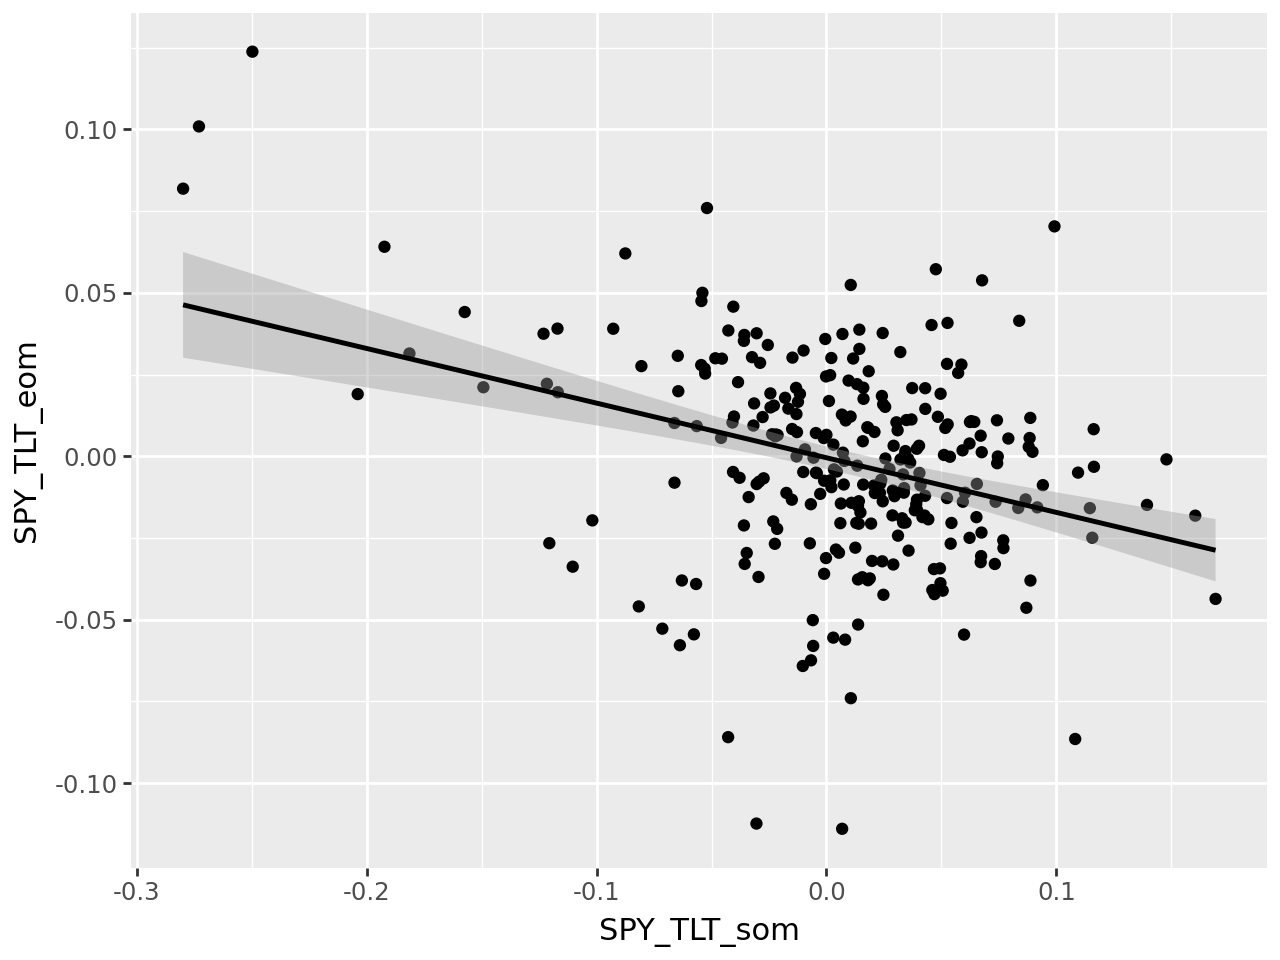

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_eom   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     35.81
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           6.71e-09
Time:                        21:25:54   Log-Likelihood:                 591.45
No. Observations:                 279   AIC:                            -1179.
Df Residuals:                     277   BIC:                            -1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0005      0.002     -0.262      

In [96]:
# plot using plotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som', y='SPY_TLT_eom')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()                                                           # have to explicitly call show otherwise only get print statement below

mod = smf.ols('SPY_TLT_eom ~ SPY_TLT_som', return_data)
res = mod.fit()
print(res.summary())

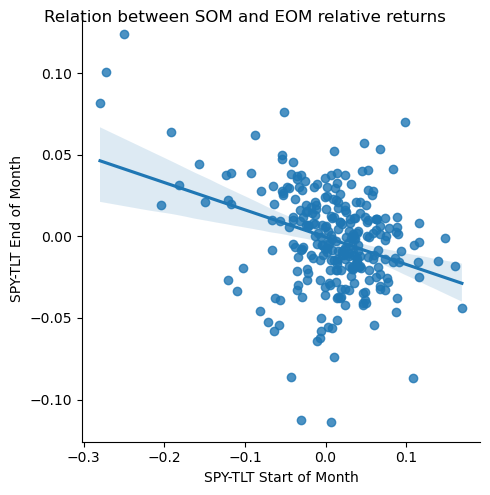

In [97]:
# plot using seaborn with customization
g = sns.lmplot(x='SPY_TLT_som', y='SPY_TLT_eom', data=return_data)
g.set_axis_labels('SPY-TLT Start of Month', 'SPY-TLT End of Month')
g.fig.suptitle('Relation between SOM and EOM relative returns')
plt.show()

## Relationship between EOM and Next SOM

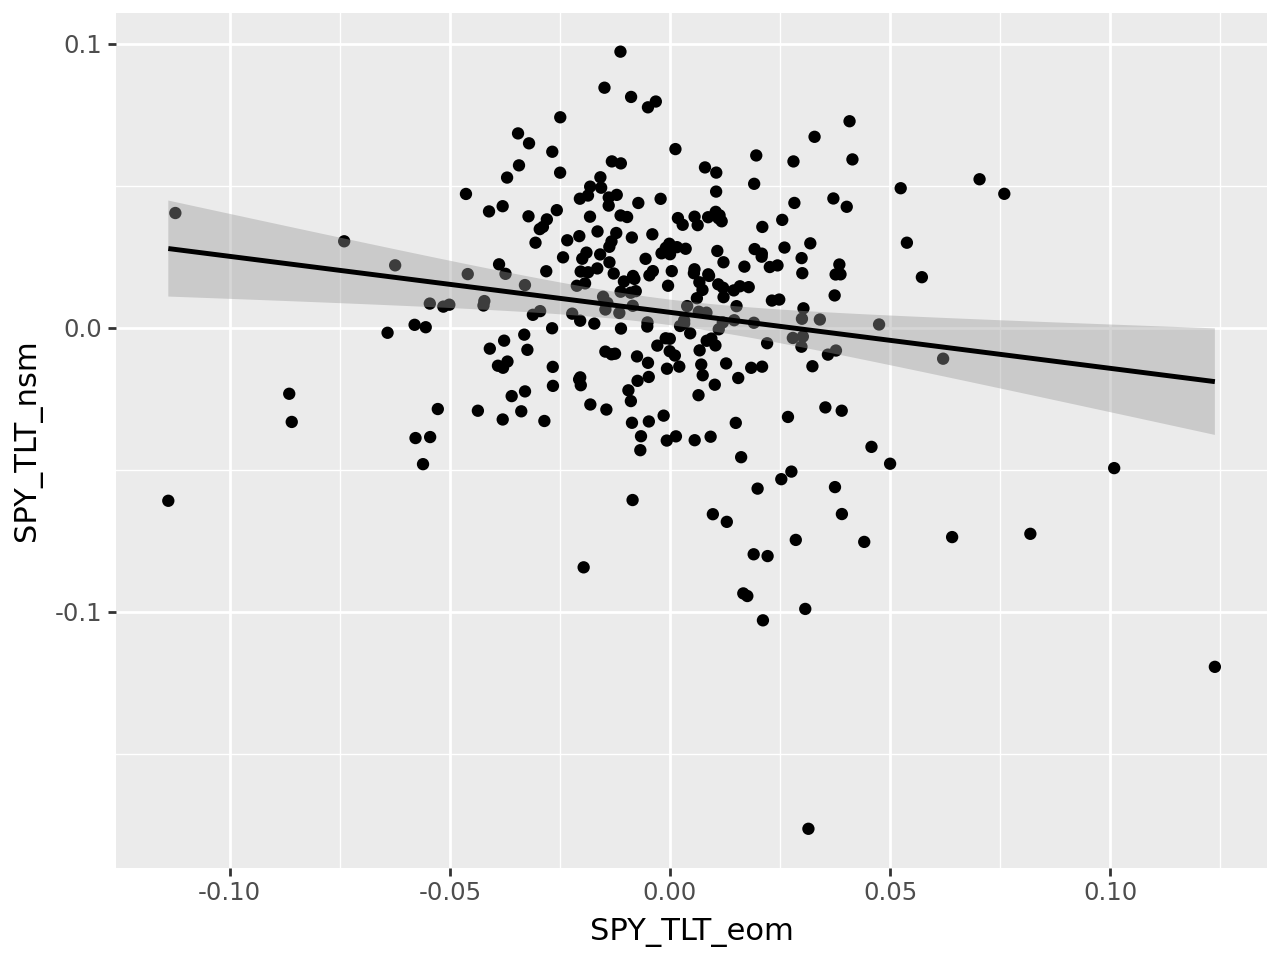

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.143
Date:                Thu, 30 Oct 2025   Prob (F-statistic):            0.00797
Time:                        21:25:55   Log-Likelihood:                 517.13
No. Observations:                 279   AIC:                            -1030.
Df Residuals:                     277   BIC:                            -1023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0054      0.002      2.382      

In [98]:
# plot using pilotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_eom', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_eom', return_data)
res = mod.fit()
print(res.summary())

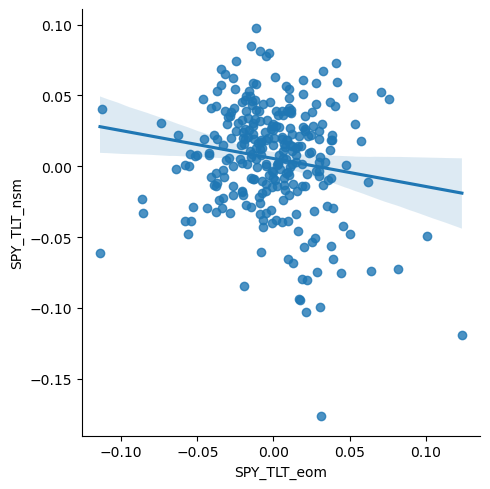

In [99]:
# plot using seaborn
sns.lmplot(x='SPY_TLT_eom', y='SPY_TLT_nsm', data=return_data)
plt.show()

## Relationship between SOM and Next SOM

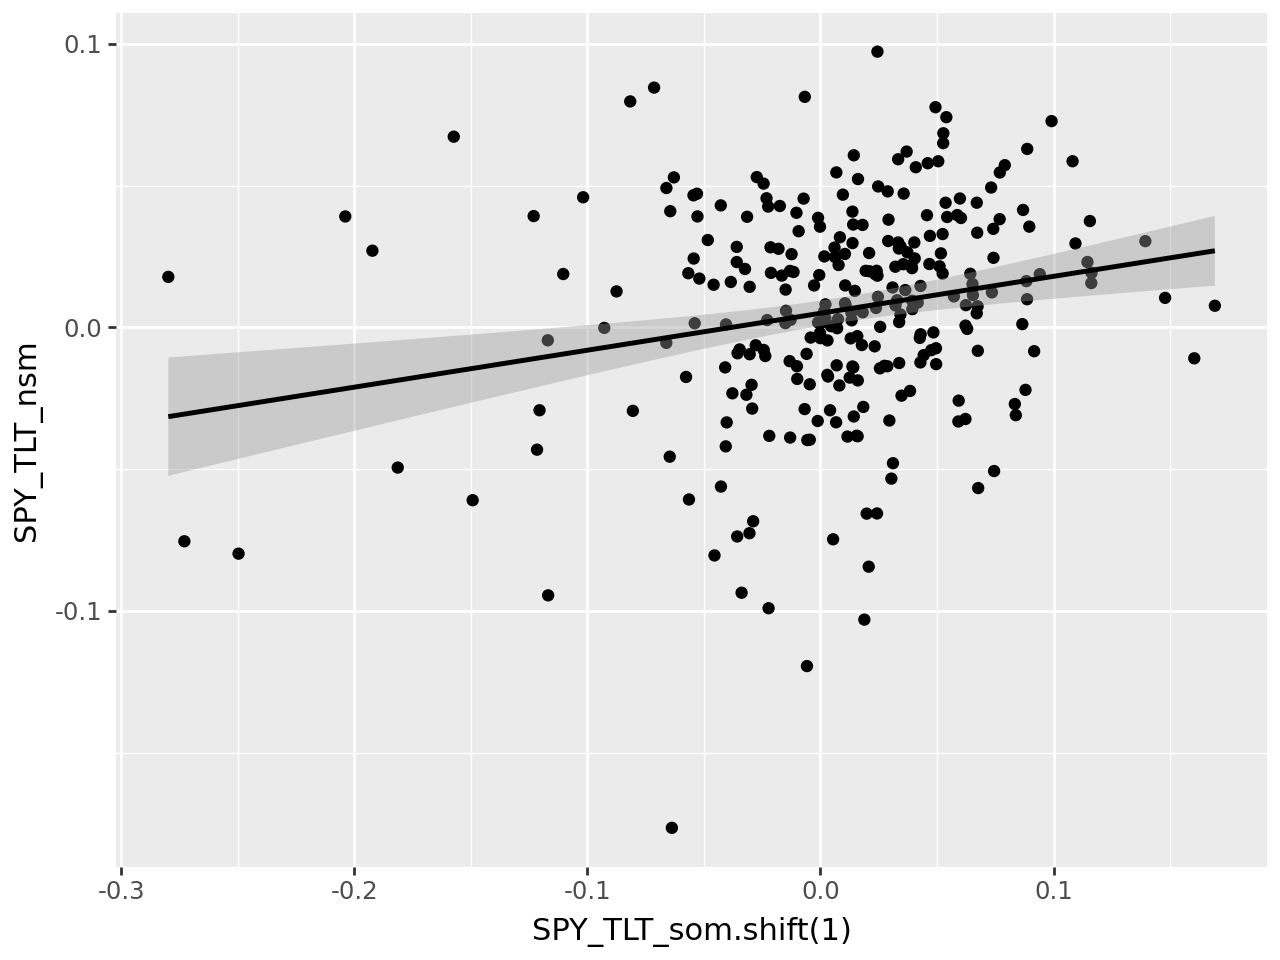

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     13.07
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           0.000357
Time:                        21:25:55   Log-Likelihood:                 518.66
No. Observations:                 278   AIC:                            -1033.
Df Residuals:                     276   BIC:                            -1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0050 

In [100]:
# plot using plotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som.shift(1)', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_som.shift(1)', return_data)
res = mod.fit()
print(res.summary())

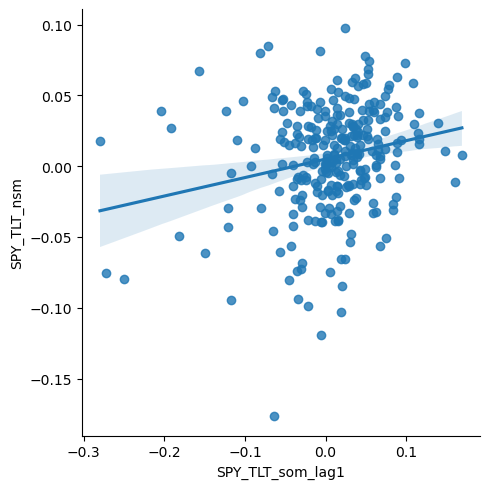

In [101]:
# Create shifted column, then plot using seaborn
return_data_shifted = return_data.assign(SPY_TLT_som_lag1=lambda x: x['SPY_TLT_som'].shift(1))

sns.lmplot(x='SPY_TLT_som_lag1', y='SPY_TLT_nsm', data=return_data_shifted)
plt.show()

## Backtesting

In [102]:
return_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469
2002-10-31,0.082284,0.169239,-0.043637,-0.029225
2002-11-30,0.061681,0.062208,0.003901,0.007640
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310


In [103]:
# Generate the trading flag
# If SPY_TLT_som < 0 → flag = +1 (LONG TLT / SHORT SPY)
# Else → flag = -1 (LONG SPY / SHORT TLT)

pl_data = return_data.copy()
pl_data['flag'] = np.where(pl_data['SPY_TLT_som'] < 0, 1, -1)

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag
ym,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049,-1
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469,1
2002-10-31,0.082284,0.169239,-0.043637,-0.029225,-1
2002-11-30,0.061681,0.062208,0.003901,0.007640,-1
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310,1


In [104]:
# Compute P/L for the end-of-month (EOM) window
# Multiply the flag by SPY_TLT_eom (the relative performance)

pl_data['SPY_TLT_eom_pl'] = pl_data['flag'] * pl_data['SPY_TLT_eom']

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl
ym,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049,-1,0.056100
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469,1,-0.026589
2002-10-31,0.082284,0.169239,-0.043637,-0.029225,-1,0.043637
2002-11-30,0.061681,0.062208,0.003901,0.007640,-1,-0.003901
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310,1,-0.037997


In [105]:
# Compute P/L for the next-start-of-month (NSM) window
# Use the opposite position of the previous month (shifted flag)
# Fill the first NaN value with 0.0 since no previous signal exists

pl_data['flag_shifted'] = pl_data['flag'].shift(1)
pl_data['SPY_TLT_nsm_pl'] = (-pl_data['flag_shifted'] * pl_data['SPY_TLT_nsm']).fillna(0.0)

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl
ym,,,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049,-1,0.056100,NaN,0.000000
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469,1,-0.026589,-1.0,-0.020469
2002-10-31,0.082284,0.169239,-0.043637,-0.029225,-1,0.043637,1.0,0.029225
2002-11-30,0.061681,0.062208,0.003901,0.007640,-1,-0.003901,-1.0,0.007640
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310,1,-0.037997,-1.0,-0.032310


In [106]:
# Compute total monthly P/L
# Combine the EOM and NSM profits/losses

pl_data['pl'] = pl_data['SPY_TLT_eom_pl'] + pl_data['SPY_TLT_nsm_pl']

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl
ym,,,,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049,-1,0.056100,NaN,0.000000,0.056100
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469,1,-0.026589,-1.0,-0.020469,-0.047058
2002-10-31,0.082284,0.169239,-0.043637,-0.029225,-1,0.043637,1.0,0.029225,0.072862
2002-11-30,0.061681,0.062208,0.003901,0.007640,-1,-0.003901,-1.0,0.007640,0.003739
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310,1,-0.037997,-1.0,-0.032310,-0.070307


In [107]:
"""
cpl_full, green, combined P&L from month end and next start of month
cpl_nsm, blue, combined P&L from next start of month only

""";

In [108]:
# Compute cumulative returns
# (1 + return).cumprod() gives the total compounded performance

pl_data['cpl_nsm'] = (1 + pl_data['SPY_TLT_nsm_pl']).cumprod()
pl_data['cpl_full'] = (1 + pl_data['pl']).cumprod()
pl_data['SPY'] = (1 + pl_data['SPY_ret']).cumprod()

pl_data.head()

,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
ym,,,,,,,,,,,,
2002-08-31,0.006801,0.008097,-0.056100,-0.048049,-1,0.056100,NaN,0.000000,0.056100,1.000000,1.056100,1.006801
2002-09-30,-0.104852,-0.120566,-0.026589,-0.020469,1,-0.026589,-1.0,-0.020469,-0.047058,0.979531,1.006402,0.901236
2002-10-31,0.082284,0.169239,-0.043637,-0.029225,-1,0.043637,1.0,0.029225,0.072862,1.008158,1.079731,0.975393
2002-11-30,0.061681,0.062208,0.003901,0.007640,-1,-0.003901,-1.0,0.007640,0.003739,1.015860,1.083768,1.035556
2002-12-31,-0.056570,-0.062908,-0.037997,-0.032310,1,-0.037997,-1.0,-0.032310,-0.070307,0.983038,1.007572,0.976975


In [109]:
# Reset index for visualization and final output

pl_data = pl_data.reset_index()

pl_data.tail()

,ym,SPY_ret,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm,flag,SPY_TLT_eom_pl,flag_shifted,SPY_TLT_nsm_pl,pl,cpl_nsm,cpl_full,SPY
274,2025-06-30,0.051386,0.010480,0.012145,0.023078,-1,-0.012145,-1.0,0.023078,0.010933,7.050890,31.596993,10.386587
275,2025-07-31,0.023032,0.033781,0.000007,0.025906,-1,-0.000007,-1.0,0.025906,0.025899,7.233553,32.415322,10.625806
276,2025-08-31,0.020520,0.006702,0.012749,-0.012571,-1,-0.012749,-1.0,-0.012571,-0.025320,7.142621,31.594573,10.843843
277,2025-09-30,0.035620,0.007519,-0.008637,-0.033473,-1,0.008637,-1.0,-0.033473,-0.024836,6.903537,30.809902,11.230105
278,2025-10-31,0.031838,-0.025525,0.034042,0.002909,1,0.034042,-1.0,0.002909,0.036951,6.923618,31.948344,11.587652


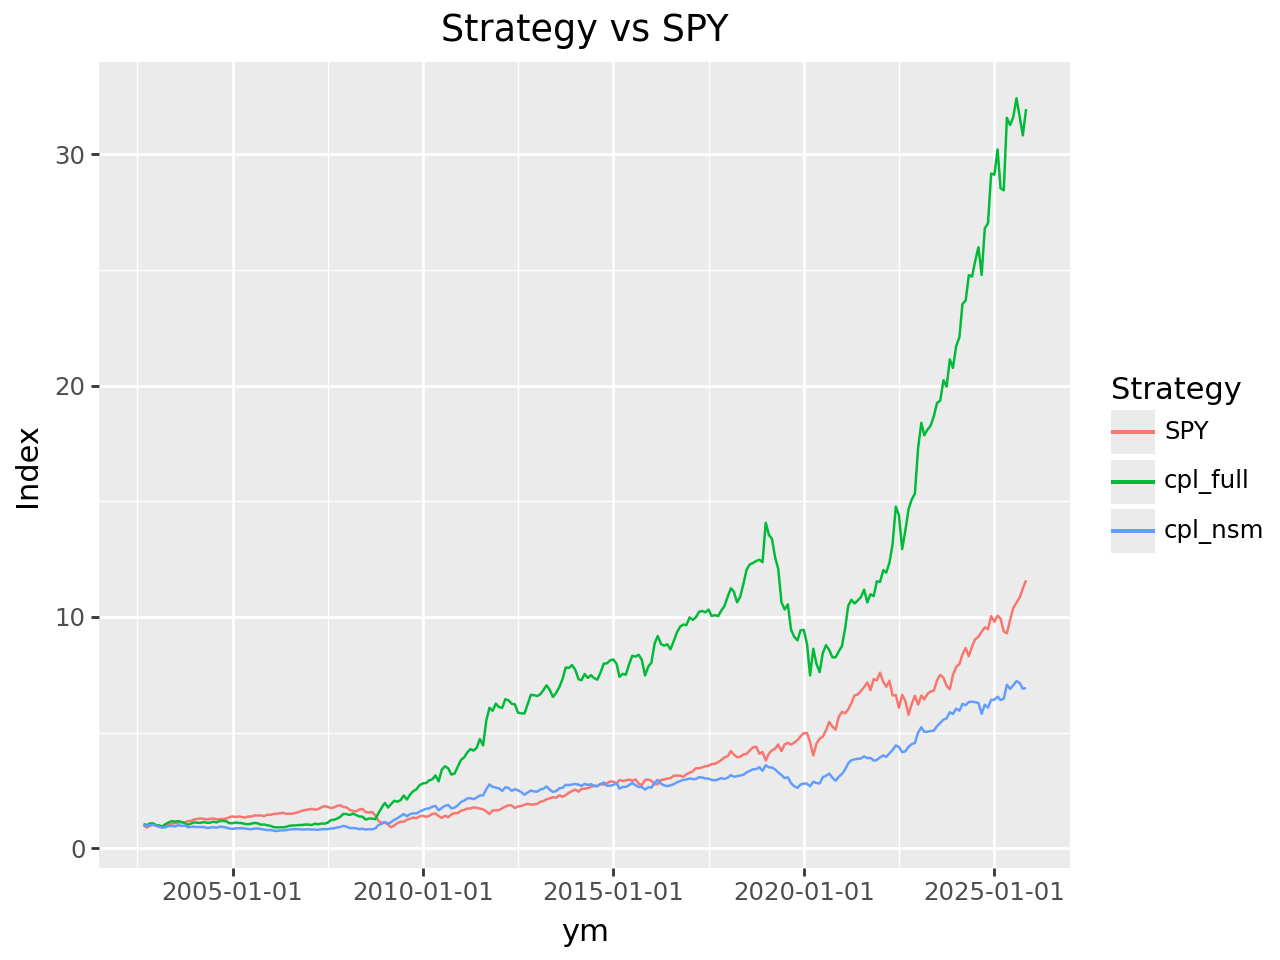

In [110]:
(
    pl_data
    [['ym', 'cpl_nsm', 'cpl_full', 'SPY']]
    .melt(id_vars='ym', var_name='Strategy', value_name='Index')
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='Index', color='Strategy')
    + p9.geom_line()
    + p9.ggtitle('Strategy vs SPY')
)

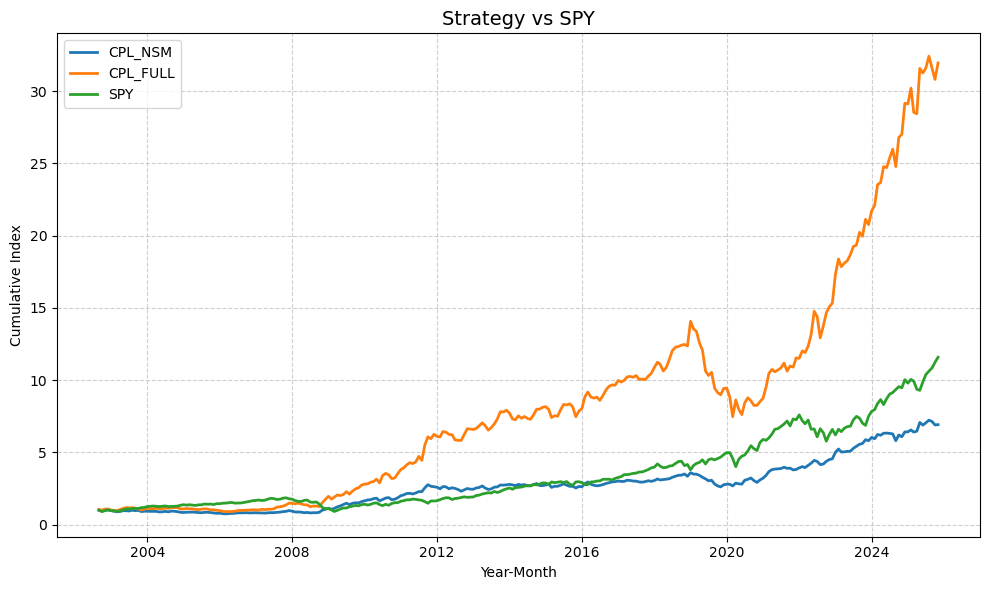

In [111]:
# Prepare data
df_plot = pl_data[['ym', 'cpl_nsm', 'cpl_full', 'SPY']].copy()

# Create the figure
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(df_plot['ym'], df_plot['cpl_nsm'], label='CPL_NSM', linewidth=2)
plt.plot(df_plot['ym'], df_plot['cpl_full'], label='CPL_FULL', linewidth=2)
plt.plot(df_plot['ym'], df_plot['SPY'], label='SPY', linewidth=2)

# Add title and labels
plt.title('Strategy vs SPY', fontsize=14)
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Index')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

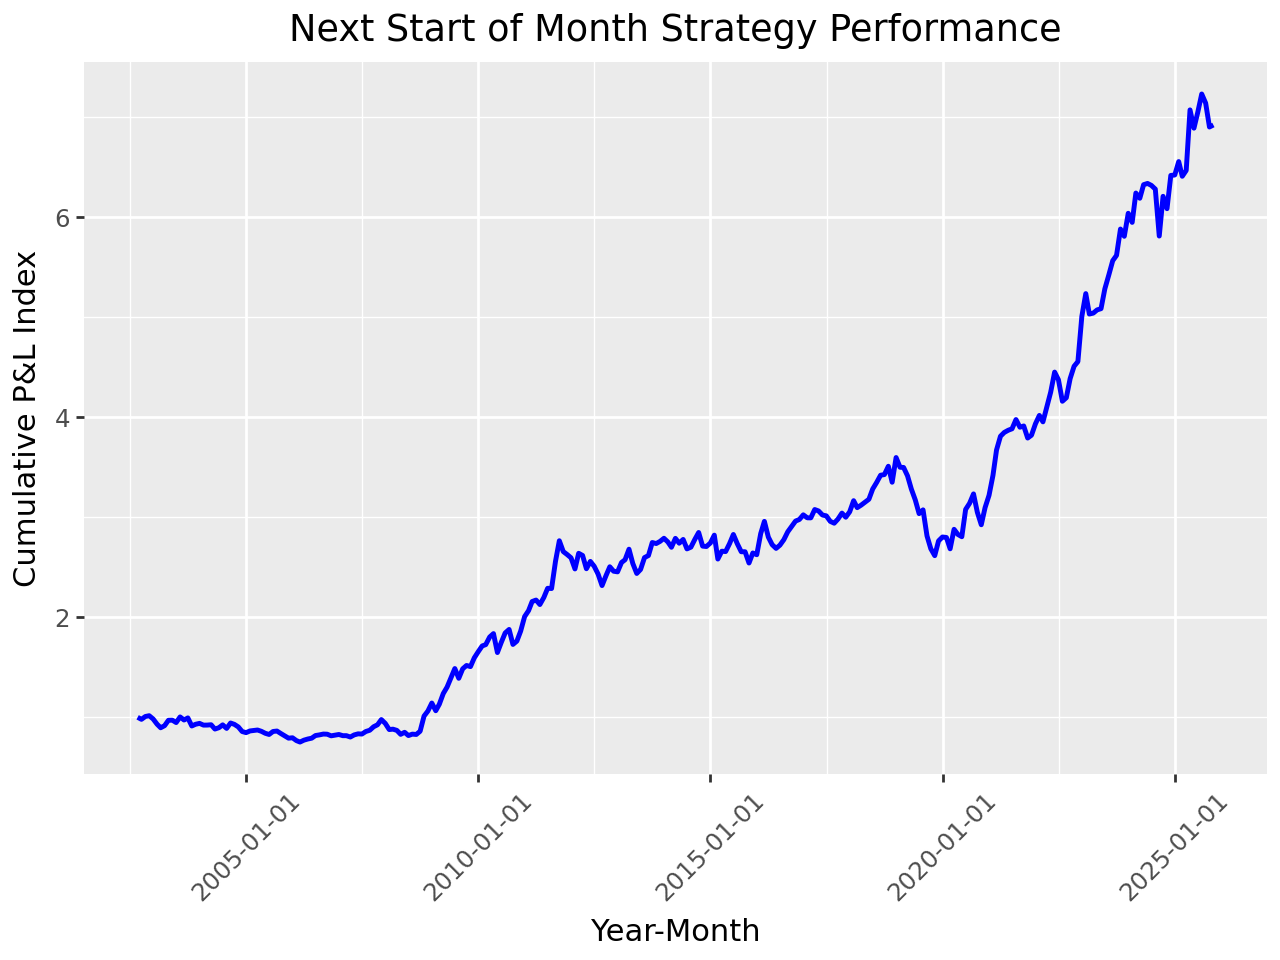

In [112]:
# Plot Next Start of Month Strategy only
(
    pl_data
    [['ym', 'cpl_nsm']]
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='cpl_nsm')
    + p9.geom_line(color='blue', size=1)
    + p9.ggtitle('Next Start of Month Strategy Performance')
    + p9.xlab('Year-Month')
    + p9.ylab('Cumulative P&L Index')
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
)

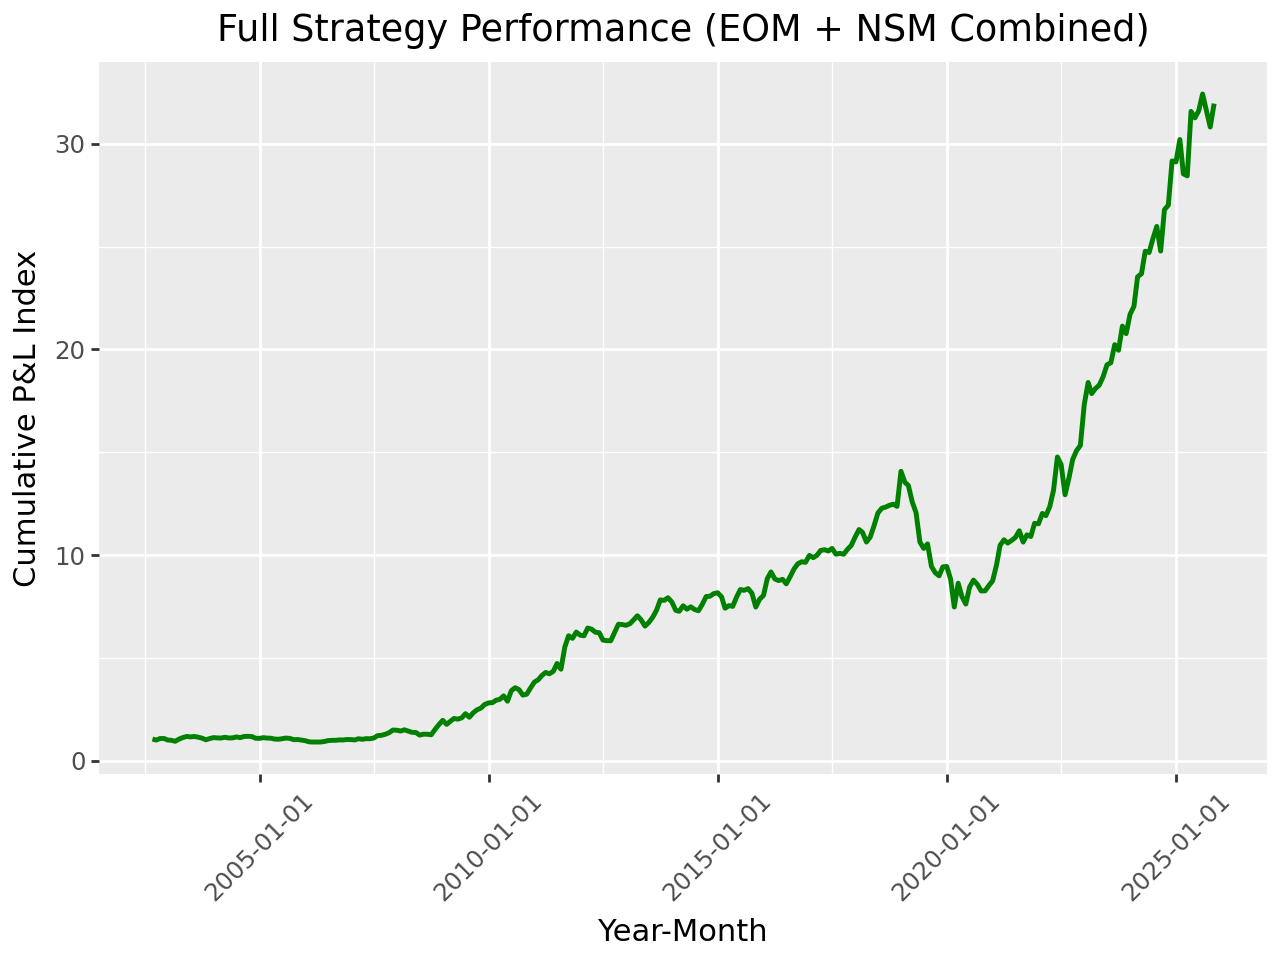

In [113]:
# Plot Full Strategy only
(
    pl_data
    [['ym', 'cpl_full']]
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='cpl_full')
    + p9.geom_line(color='green', size=1)
    + p9.ggtitle('Full Strategy Performance (EOM + NSM Combined)')
    + p9.xlab('Year-Month')
    + p9.ylab('Cumulative P&L Index')
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
)

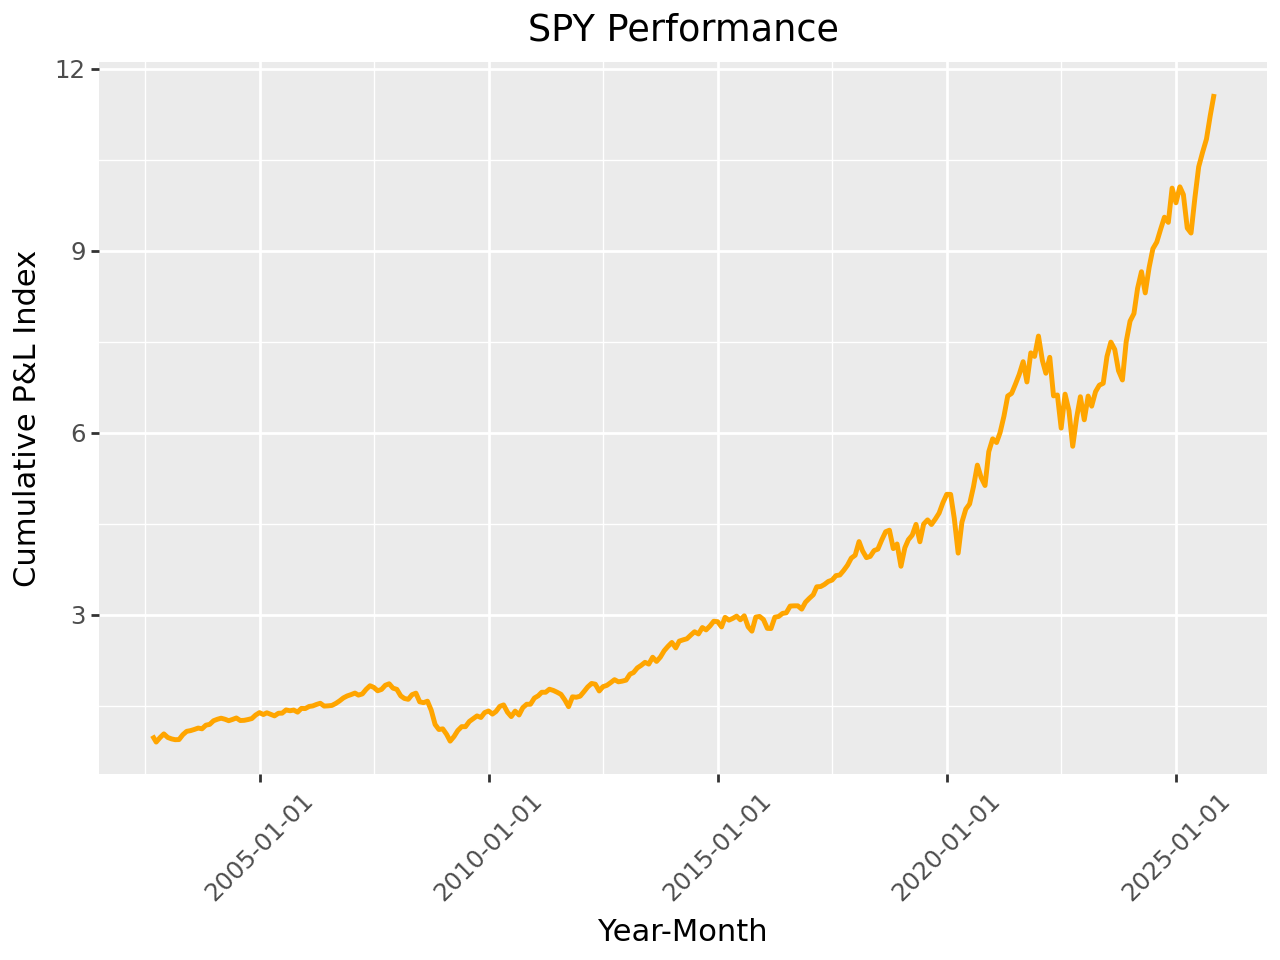

In [114]:
# Plot SPY only
(
    pl_data
    [['ym', 'SPY']]
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='SPY')
    + p9.geom_line(color='orange', size=1)
    + p9.ggtitle('SPY Performance')
    + p9.xlab('Year-Month')
    + p9.ylab('Cumulative P&L Index')
    + p9.theme(axis_text_x=p9.element_text(rotation=45))
)

In [115]:
ret_strategy = pl_data['pl'].mean() * 12
vol_strategy = pl_data['pl'].std() * np.sqrt(12)
sr_strategy = ret_strategy / vol_strategy
mdd_strategy = (pl_data['cpl_full']/pl_data['cpl_full'].expanding().max() - 1.0).min()

ret_nsm = pl_data['SPY_TLT_nsm_pl'].mean() * 12
vol_nsm = pl_data['SPY_TLT_nsm_pl'].std() * np.sqrt(12)
sr_nsm = ret_strategy / vol_strategy
mdd_nsm = (pl_data['cpl_nsm']/pl_data['cpl_nsm'].expanding().max() - 1.0).min()

ret_spy = pl_data['SPY_ret'].mean() * 12
vol_spy = pl_data['SPY_ret'].std() * np.sqrt(12)
sr_spy = ret_spy / vol_spy
mdd_spy = (pl_data['SPY'] / pl_data['SPY'].expanding().max() - 1.0).min()

print(f'Next SOM Return = {ret_nsm:.2%}, Strategy Vol = {vol_nsm:.2%}, Strategy Sharpe = {sr_nsm:.2f}, Strategy Max DrawDown = {mdd_nsm:.2%}')
print(f'Strategy Return = {ret_strategy:.2%}, Strategy Vol = {vol_strategy:.2%}, Strategy Sharpe = {sr_strategy:.2f}, Strategy Max DrawDown = {mdd_strategy:.2%}')
print(f'SPY Return      = {ret_spy:.2%}, SPY Vol      = {vol_spy:.2%}, SPY Sharpe      = {sr_spy:.2f}, SPY Max DrawDown      = {mdd_spy:.2%}')

Next SOM Return = 9.21%, Strategy Vol = 13.17%, Strategy Sharpe = 0.92, Strategy Max DrawDown = -27.28%
Strategy Return = 16.55%, Strategy Vol = 17.91%, Strategy Sharpe = 0.92, Strategy Max DrawDown = -46.88%
SPY Return      = 11.68%, SPY Vol      = 14.73%, SPY Sharpe      = 0.79, SPY Max DrawDown      = -50.78%


In [116]:
# # Compute annualized return and volatility for the full strategy
# ret_strategy = pl_data['pl'].mean() * 12       # Annualized return
# vol_strategy = pl_data['pl'].std() * np.sqrt(12)  # Annualized volatility

# # Show values
# print("Annualized Return (Strategy):", round(ret_strategy * 100, 2), "%")
# print("Annualized Volatility (Strategy):", round(vol_strategy * 100, 2), "%")

In [117]:
# # Sharpe ratio
# sr_strategy = ret_strategy / vol_strategy

# # Max Drawdown (the lowest point compared to the previous peak)
# roll_max = pl_data['cpl_full'].expanding().max()
# drawdown = (pl_data['cpl_full'] / roll_max) - 1.0
# mdd_strategy = drawdown.min()

# # Show values
# print("Sharpe Ratio (Strategy):", round(sr_strategy, 2))
# print("Max Drawdown (Strategy):", round(mdd_strategy * 100, 2), "%")

In [118]:
# # Annualized return and volatility for Next SOM version
# ret_nsm = pl_data['SPY_TLT_nsm_pl'].mean() * 12
# vol_nsm = pl_data['SPY_TLT_nsm_pl'].std() * np.sqrt(12)

# # Sharpe ratio and Max Drawdown
# sr_nsm = ret_nsm / vol_nsm
# roll_max_nsm = pl_data['cpl_nsm'].expanding().max()
# drawdown_nsm = (pl_data['cpl_nsm'] / roll_max_nsm) - 1.0
# mdd_nsm = drawdown_nsm.min()

# # Show results
# print("Next SOM Return:", round(ret_nsm * 100, 2), "%")
# print("Next SOM Volatility:", round(vol_nsm * 100, 2), "%")
# print("Next SOM Sharpe:", round(sr_nsm, 2))
# print("Next SOM Max Drawdown:", round(mdd_nsm * 100, 2), "%")

In [119]:
# # Annualized return and volatility for SPY
# ret_spy = pl_data['SPY_ret'].mean() * 12
# vol_spy = pl_data['SPY_ret'].std() * np.sqrt(12)

# # Sharpe ratio and Max Drawdown
# sr_spy = ret_spy / vol_spy
# roll_max_spy = pl_data['SPY'].expanding().max()
# drawdown_spy = (pl_data['SPY'] / roll_max_spy) - 1.0
# mdd_spy = drawdown_spy.min()

# # Show results
# print("SPY Return:", round(ret_spy * 100, 2), "%")
# print("SPY Volatility:", round(vol_spy * 100, 2), "%")
# print("SPY Sharpe:", round(sr_spy, 2))
# print("SPY Max Drawdown:", round(mdd_spy * 100, 2), "%")

In [120]:
# # Create a summary table for easy comparison
# metrics = pd.DataFrame({
#     'Return [%]': [ret_strategy * 100, ret_nsm * 100, ret_spy * 100],
#     'Volatility [%]': [vol_strategy * 100, vol_nsm * 100, vol_spy * 100],
#     'Sharpe Ratio': [sr_strategy, sr_nsm, sr_spy],
#     'Max Drawdown [%]': [mdd_strategy * 100, mdd_nsm * 100, mdd_spy * 100]
# }, index=['Full Strategy', 'Next SOM', 'SPY'])

# # Add additional metrics (optional)
# metrics['Calmar Ratio'] = metrics['Return [%]'] / abs(metrics['Max Drawdown [%]'])
# metrics['Return/Volatility'] = metrics['Return [%]'] / metrics['Volatility [%]']

# # Display summary
# print("=== Backtest Performance Summary")
# metrics.round(2)